In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels as sm
%matplotlib inline

In [2]:
wildlife = pd.read_csv('../clean_data/data_syth.csv', parse_dates=['CALL_SAVED_TIME'])

In [3]:
wildlife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152743 entries, 0 to 152742
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   X1               152743 non-null  int64         
 1   CALL_REGION      152743 non-null  object        
 2   CALL_SAVED_TIME  152672 non-null  datetime64[ns]
 3   reason_for_call  152743 non-null  object        
 4   type_of_calls    152743 non-null  object        
 5   CA_ANIMAL_TYPE   152743 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 7.0+ MB


In [4]:
wildlife.head()

,X1,CALL_REGION,CALL_SAVED_TIME,reason_for_call,type_of_calls,CA_ANIMAL_TYPE
0,0,Birmingham,2019-12-28,rescue,report_calls,Rat
1,1,Birmingham,2020-01-04,rescue,report_calls,Rat
2,2,Birmingham,2020-01-05,rescue,report_calls,Rat
3,3,Leeds,2020-01-04,injury,report_calls,Deer
4,4,Birmingham,2019-12-29,injury,report_calls,Wild Bird


# Prediction of injuries calls

## Choosing the best model through train/test split up

In [5]:
wildlife_injuries = wildlife[wildlife['reason_for_call']=='injury'].copy()
df_time = wildlife_injuries.groupby(['CALL_SAVED_TIME']).count()
df_time.head()

,X1,CALL_REGION,reason_for_call,type_of_calls,CA_ANIMAL_TYPE
CALL_SAVED_TIME,,,,,
2017-12-31,6,6,6,6,6
2018-01-01,43,43,43,43,43
2018-01-02,44,44,44,44,44
2018-01-03,58,58,58,58,58
2018-01-04,43,43,43,43,43


In [6]:
df_time = df_time[0:850].copy()

In [7]:
df_time.shape

(850, 5)

In [8]:
# to find 20% of all rows
x = 850 *0.2
850 - x

680.0

In [9]:
train=df_time[0:680] 
test=df_time[680:]

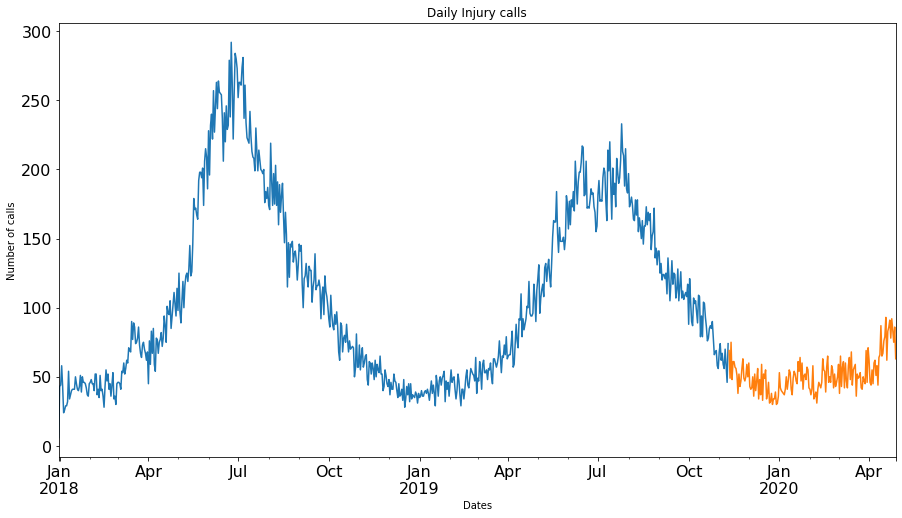

In [10]:
train.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=16)
test.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()
# injury data split into train and test 

## Naive

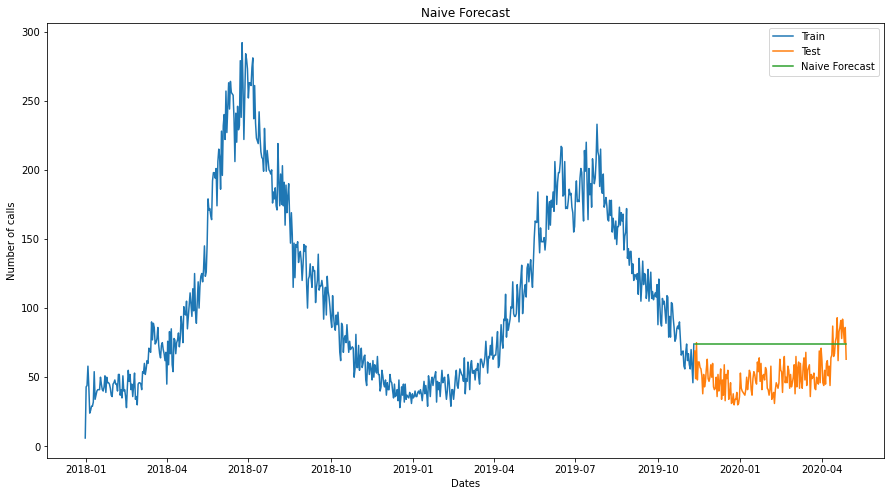

In [11]:
dd= np.asarray(train.reason_for_call)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['reason_for_call'], label='Train')
plt.plot(test.index,test['reason_for_call'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_naive = sqrt(mean_squared_error(test.reason_for_call, y_hat.naive))
print(rms_naive)

26.04746798127016


## Moving average

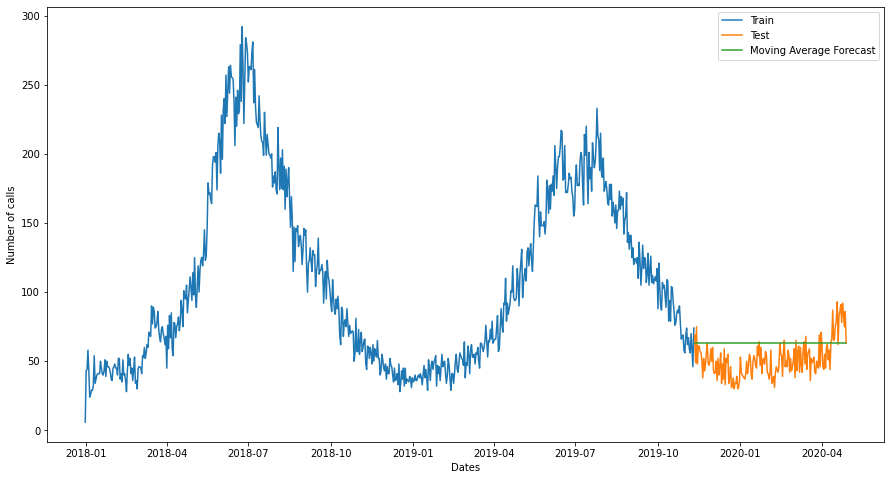

In [13]:
y_hat_avg_m = test.copy()
y_hat_avg_m['moving_avg_forecast'] = train['reason_for_call'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg_m['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [14]:
rms_avg = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg_m.moving_avg_forecast))
print(rms_avg)

17.73285418783617


## SARIMA

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


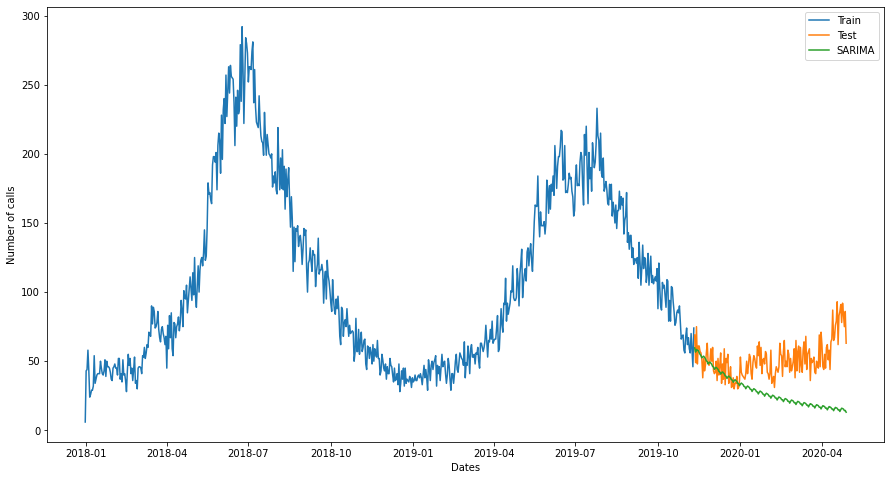

In [15]:
import statsmodels.api as sm

y_hat_avg_s = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.reason_for_call, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg_s['SARIMA'] = fit1.predict(start="2019-11-11", end="2020-04-28", dynamic=True)
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg_s['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [16]:
rms_sarima = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg_s.SARIMA))
print(rms_sarima)

30.607737682414317


## Holt Winter

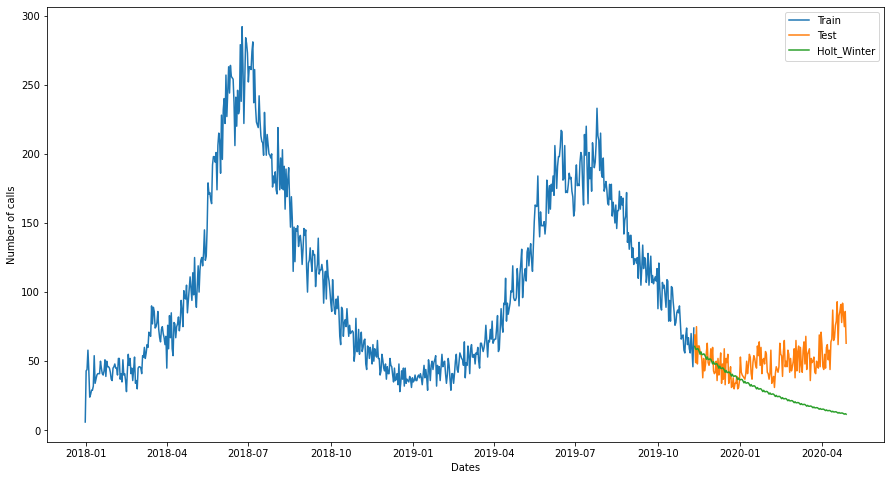

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg_h = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['reason_for_call']) ,seasonal_periods=7 ,trend='mul', seasonal='mul',).fit()
y_hat_avg_h['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg_h['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [18]:
rms_holt = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg_h.Holt_Winter))
print(rms_holt)

31.03722586089157


## SES

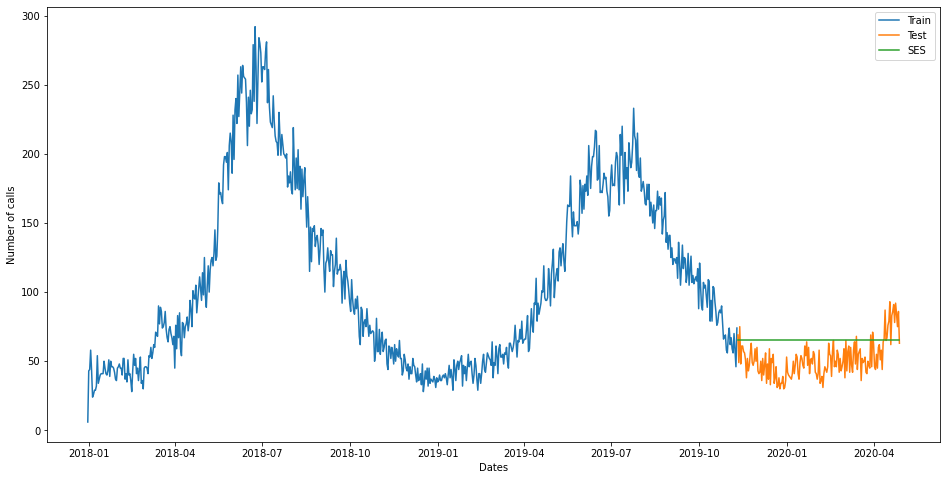

In [19]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['reason_for_call'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [20]:
rms_ses = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SES))
print(rms_ses)

18.97789403933724


## Seasonal naive

In [21]:
test_sn = test.reset_index()
train_sn = train.reset_index()

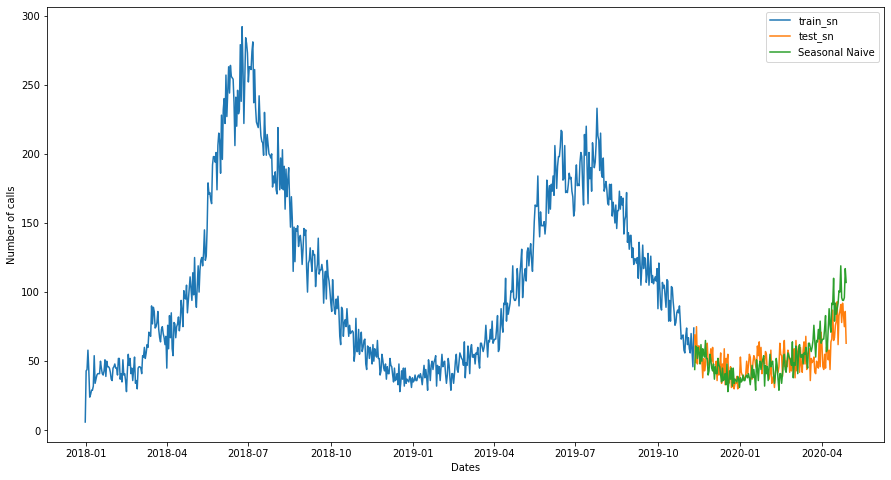

In [22]:
dates = (test_sn['CALL_SAVED_TIME'] - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
seasonal_naive = train_sn[train_sn['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = test_sn.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(test_sn.index)
plt.figure(figsize=(15,8))
plt.plot(train_sn['CALL_SAVED_TIME'], train_sn['reason_for_call'], label='train_sn')
plt.plot(test_sn['CALL_SAVED_TIME'], test_sn['reason_for_call'], label='test_sn')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [23]:
rms_snaive = sqrt(mean_squared_error(test_sn.reason_for_call, y_hat_sn.seasonal_naive))
print(rms_snaive)

13.893502501698622


# Summary of models

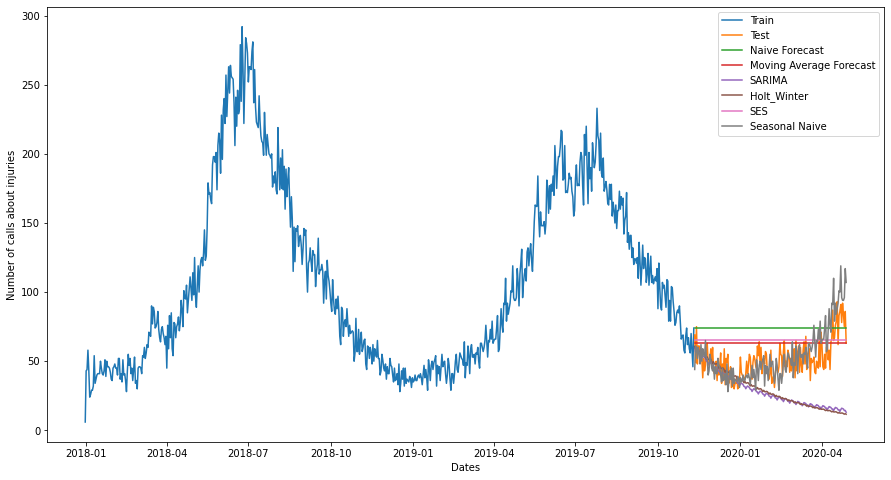

In [24]:
plt.figure(figsize=(15,8))
plt.plot(train.index, train['reason_for_call'], label='Train')
plt.plot(test.index,test['reason_for_call'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.plot(y_hat_avg_m['moving_avg_forecast'], label='Moving Average Forecast')
plt.plot(y_hat_avg_s['SARIMA'], label='SARIMA')
plt.plot(y_hat_avg_h['Holt_Winter'], label='Holt_Winter')
plt.plot(y_hat_avg['SES'], label='SES')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls about injuries')
plt.show()

**Summary of models**

| Model| RMSE |
| :---| :--- |  
| Naive | 26.05 |
| Moving avg | 17.73 |
| SARIMA | 30.61 |
| Holt Winter | 31.04 |
| SES | 18.98 |
| SNaive | 13.89 |

Out of 6 models, the lowest RMSE has SNaive model and will be used for further forecasting.

# Forecasting modelling

## Injuries predictions

In [25]:
test.tail()

,X1,CALL_REGION,reason_for_call,type_of_calls,CA_ANIMAL_TYPE
CALL_SAVED_TIME,,,,,
2020-04-24,92,92,92,92,92
2020-04-25,84,84,84,84,84
2020-04-26,75,75,75,75,75
2020-04-27,86,86,86,86,86
2020-04-28,63,63,63,63,63


In [26]:
rng = pd.date_range('2020-04-28', periods=610, freq='D')
df_pred = pd.DataFrame({ 'CALL_SAVED_TIME': rng, 'reason_for_call' : np.random.randn(len(rng))}) 
df_pred.head()
# creating dummy data with dates that will be interest in the future

,CALL_SAVED_TIME,reason_for_call
0,2020-04-28,1.695205
1,2020-04-29,0.468520
2,2020-04-30,0.460780
3,2020-05-01,1.544733
4,2020-05-02,1.033263


In [27]:
injury_data = df_time.reset_index()

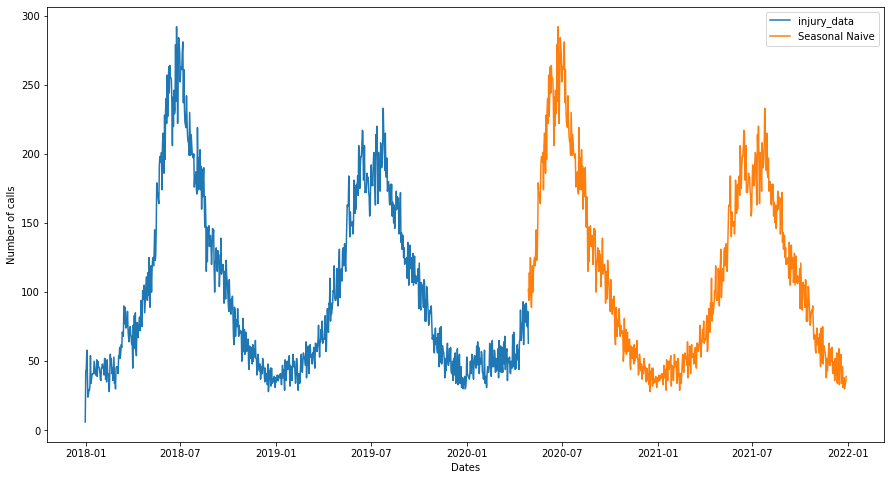

In [28]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = injury_data[injury_data['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(injury_data['CALL_SAVED_TIME'], injury_data['reason_for_call'], label='injury_data')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [29]:
y_hat_sn.head()
#predicted numbers in seasonal_naive

,CALL_SAVED_TIME,seasonal_naive
0,2020-04-28,102
1,2020-04-29,94
2,2020-04-30,114
3,2020-05-01,98
4,2020-05-02,125


## All calls predictions

In [30]:
calls = wildlife.groupby('CALL_SAVED_TIME').count()
calls.head()

,X1,CALL_REGION,reason_for_call,type_of_calls,CA_ANIMAL_TYPE
CALL_SAVED_TIME,,,,,
2017-12-31,8,8,8,8,8
2018-01-01,72,72,72,72,72
2018-01-02,77,77,77,77,77
2018-01-03,108,108,108,108,108
2018-01-04,102,102,102,102,102


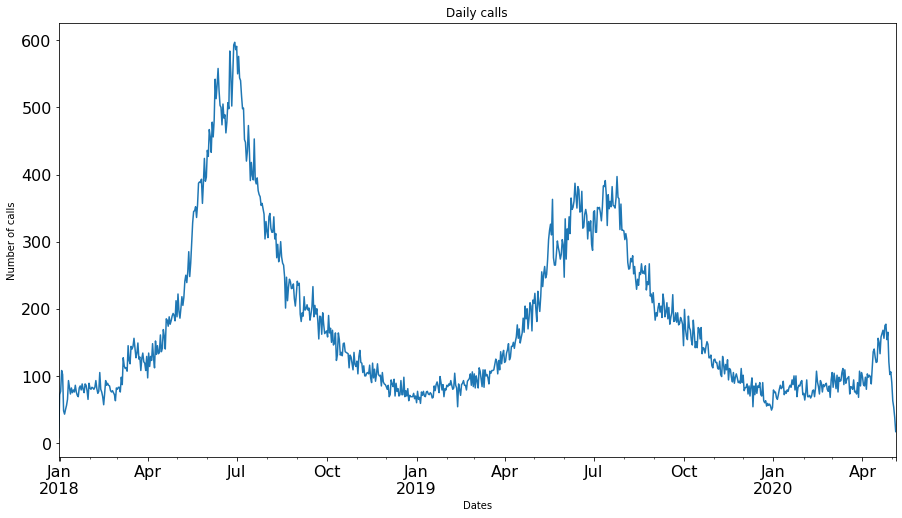

In [31]:
calls.type_of_calls.plot(figsize=(15,8), title= 'Daily calls', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [32]:
calls = calls.reset_index()

In [33]:
calls = calls[0:850].copy()

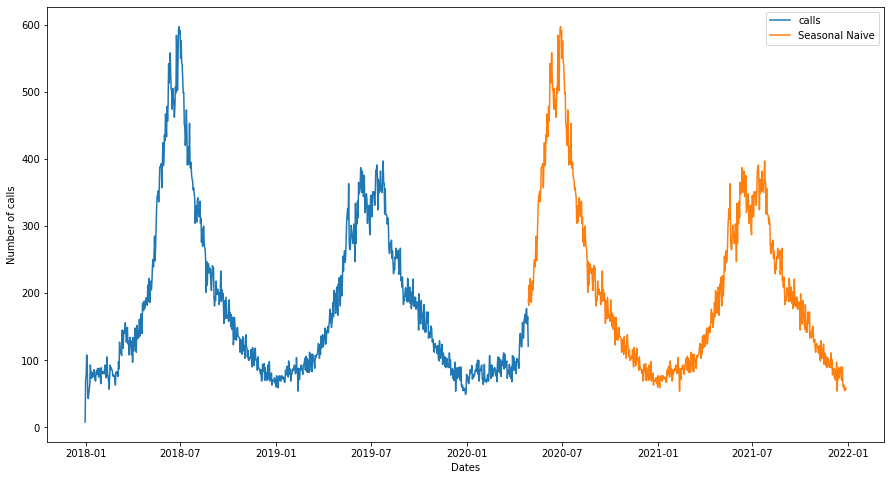

In [34]:
dates = (df_pred['CALL_SAVED_TIME'] - np.timedelta64(2, 'Y')).values.astype('datetime64[D]')
seasonal_naive = calls[calls['CALL_SAVED_TIME'].isin(dates)]['reason_for_call'] # seasonal naive prediction
y_hat_sn = df_pred.copy().drop('reason_for_call', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(df_pred.index)
plt.figure(figsize=(15,8))
plt.plot(calls['CALL_SAVED_TIME'], calls['reason_for_call'], label='calls')
plt.plot(y_hat_sn['CALL_SAVED_TIME'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Dates')
plt.ylabel('Number of calls')
plt.show()

In [35]:
y_hat_sn.head()
# predicted numbers in seasonal_naive

,CALL_SAVED_TIME,seasonal_naive
0,2020-04-28,190
1,2020-04-29,182
2,2020-04-30,212
3,2020-05-01,188
4,2020-05-02,222


In summary, these two models look similar to each other, it is only the calls model has more number of calls as it includes all the calls, while injuries include only injuries calls. Also, SNaive just repeats what happened in the past at the same season. So it looks like the predictions is overfitted because there is no trend noticed (which is the decreasing one). There are low chances that the future will be exactly the same as the past. SNaive is good for short period prediction - few weeks/months ahead. This is why Prophet model was decided to perform as it is more complex than Snaive and will allow to see the errors with which it predicts.

# Prophet

In [36]:
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet 0.6


In [37]:
df_time = df_time.reset_index()

In [38]:
df_prophet = df_time.loc[:,['CALL_SAVED_TIME','reason_for_call']].copy()
df_prophet = pd.DataFrame(df_prophet).copy()
df_prophet.columns = ['ds', 'y']
#prophet requires ds and y columns

In [39]:
from fbprophet import Prophet
model = Prophet()
# fit the model
model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds        yhat  yhat_lower  yhat_upper
7  2020-08-01  158.093438  140.828324  175.945557
8  2020-09-01   97.635296   79.641564  115.031752
9  2020-10-01   66.873455   45.996210   87.760147
10 2020-11-01   25.920789    2.409733   48.689122
11 2020-12-01    6.965850  -19.067941   32.112658


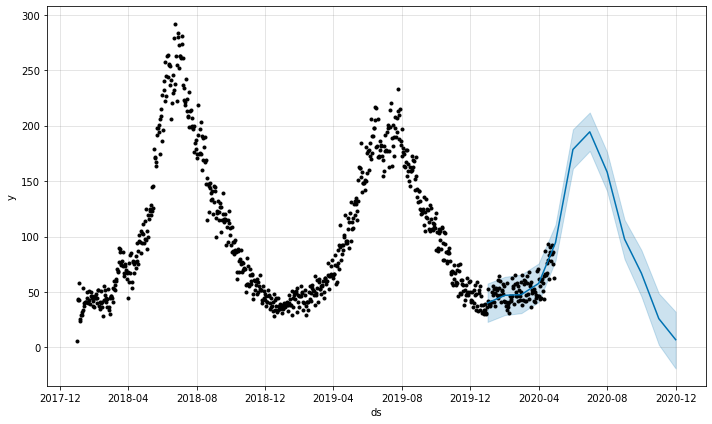

In [40]:
from datetime import datetime
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

In [41]:
#create 20 months of future data
future_data = model.make_future_dataframe(periods=20, freq = 'm')

#forecast the data for future data
forecast_data = model.predict(future_data)

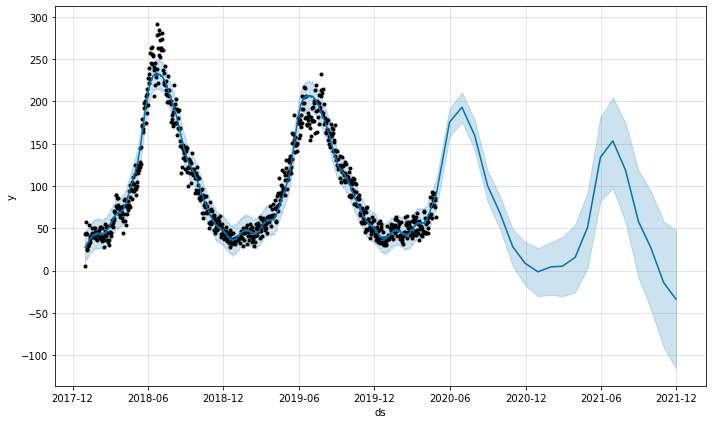

In [42]:
model.plot(forecast_data);

In [43]:
forecast = model.predict(future_data)
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
df

,ds,yhat,yhat_lower,yhat_upper
0,2017-12-31,27.271814,9.049705,44.801930
1,2018-01-01,28.497772,12.242647,46.038689
2,2018-01-02,28.101670,11.470902,44.430384
3,2018-01-03,30.515970,13.608593,47.231614
4,2018-01-04,31.390851,14.579412,47.390445
...,...,...,...,...
865,2021-07-31,118.489832,57.112761,177.858726
866,2021-08-31,58.170913,-10.911079,124.504061
867,2021-09-30,27.177553,-48.899951,97.609854
868,2021-10-31,-14.185310,-95.387533,63.200854


In [44]:
start_date = "2020-05-01"
end_date = "2021-12-31"

after_start_date = df["ds"] >= start_date
before_end_date = df["ds"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = df.loc[between_two_dates]
filtered_dates

,ds,yhat,yhat_lower,yhat_upper
851,2020-05-31,175.538551,159.177512,193.531933
852,2020-06-30,193.155876,176.663607,210.536390
853,2020-07-31,159.669553,142.442448,178.791970
854,2020-08-31,100.357102,81.775603,119.269645
855,2020-09-30,68.199968,48.375654,88.551548
856,2020-10-31,28.177208,6.359702,50.319471
857,2020-11-30,8.645418,-15.920527,33.450908
858,2020-12-31,-1.358422,-29.395604,27.034036
859,2021-01-31,4.447247,-25.950111,36.100567
860,2021-02-28,5.200485,-29.324766,43.047228


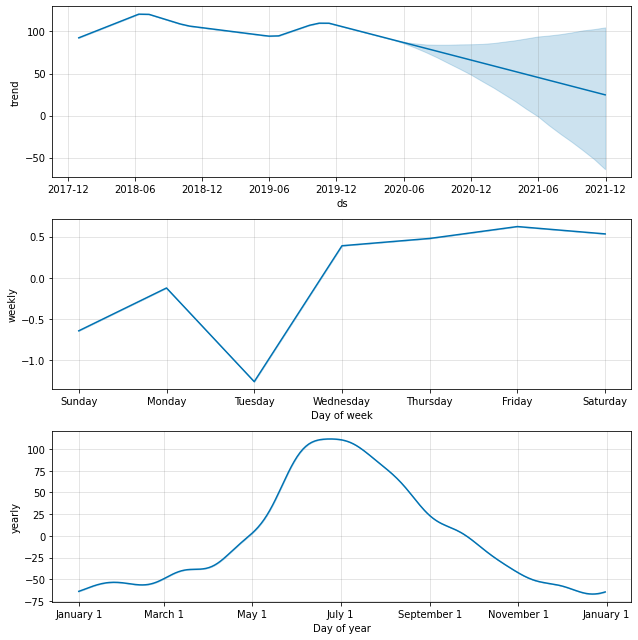

In [45]:
model.plot_components(forecast);

Prophet shows trend in general, weekly and yearly. It also shows prediction for all 2021 year. Although, there is only 2 seasons in data so it might be too risky to say that the trend is decreasing. Also some values are negative and it cannot be true. 

# Cross validation of Prophet

In [46]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='540 days', period='90 days', horizon = '180 days')
df_cv.head()
# y is true value and ythat is predicted

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-08-02 00:00:00 and 2019-10-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-03,163.309761,144.816290,181.661722,176,2019-08-02
1,2019-08-04,159.987673,142.501414,178.689645,180,2019-08-02
2,2019-08-05,157.342151,138.626233,176.982397,174,2019-08-02
3,2019-08-06,153.694321,134.716048,172.523933,164,2019-08-02
4,2019-08-07,153.215790,135.269526,171.025795,163,2019-08-02


In [47]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,546.885603,23.385585,19.766668,0.202390,0.163456,0.527778
1,19 days,647.408525,25.444224,21.413549,0.218957,0.193892,0.472222
2,20 days,755.941560,27.494391,23.340743,0.252093,0.215502,0.444444
3,21 days,864.618416,29.404395,24.912833,0.267140,0.248249,0.388889
4,22 days,932.557840,30.537810,26.413452,0.291624,0.253052,0.333333


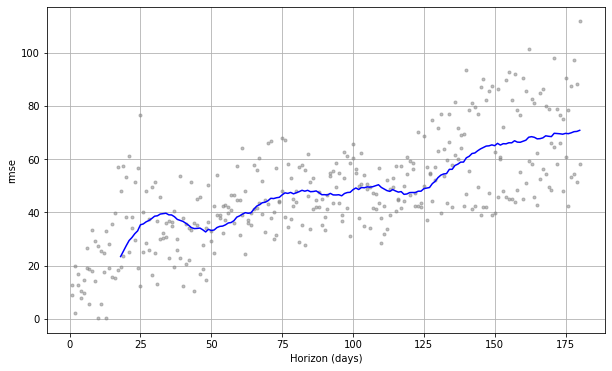

In [48]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
# rmse increasing as hoizon increases (how far into the future the prediction was)

# Volume of calls

In [49]:
prophet_calls = calls.loc[:,['CALL_SAVED_TIME','type_of_calls']].copy()
prophet_calls = pd.DataFrame(prophet_calls).copy()
prophet_calls.columns = ['ds', 'y']

In [50]:
model_calls = Prophet()
model_calls.fit(prophet_calls)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


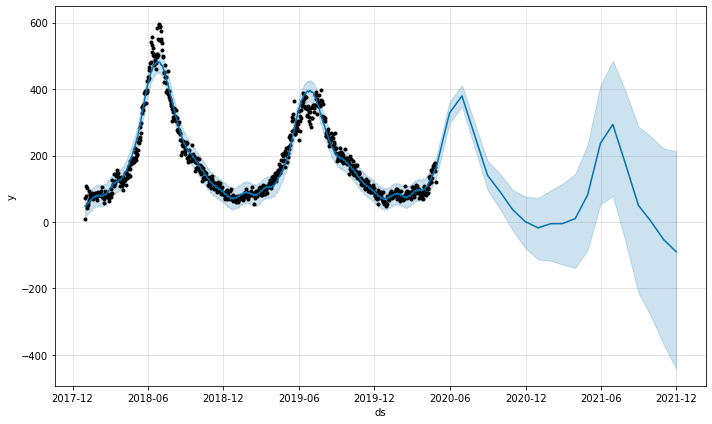

In [51]:
#create 20 months of future data
future_data_calls = model_calls.make_future_dataframe(periods=20, freq = 'm')

#forecast the data for future data
forecast_data_calls = model_calls.predict(future_data_calls)

model_calls.plot(forecast_data_calls);

In [52]:
forecast_calls = model_calls.predict(future_data_calls)
df_calls = forecast_calls[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

In [53]:
after_start_date_calls = df_calls["ds"] >= start_date
before_end_date_calls = df_calls["ds"] <= end_date
between_two_dates_calls = after_start_date_calls & before_end_date_calls
filtered_dates_calls = df_calls.loc[between_two_dates_calls]
filtered_dates_calls

,ds,yhat,yhat_lower,yhat_upper
851,2020-05-31,328.332559,296.345621,361.228382
852,2020-06-30,379.312226,344.891624,413.659110
853,2020-07-31,260.000943,221.287493,296.898343
854,2020-08-31,140.356990,94.262351,181.867853
855,2020-09-30,91.448544,37.841713,142.784401
856,2020-10-31,36.876351,-26.928242,97.801833
857,2020-11-30,1.495270,-78.037604,75.244320
858,2020-12-31,-17.483524,-116.530444,71.126314
859,2021-01-31,-5.039770,-127.183568,99.027916
860,2021-02-28,-4.818150,-139.878268,111.424582


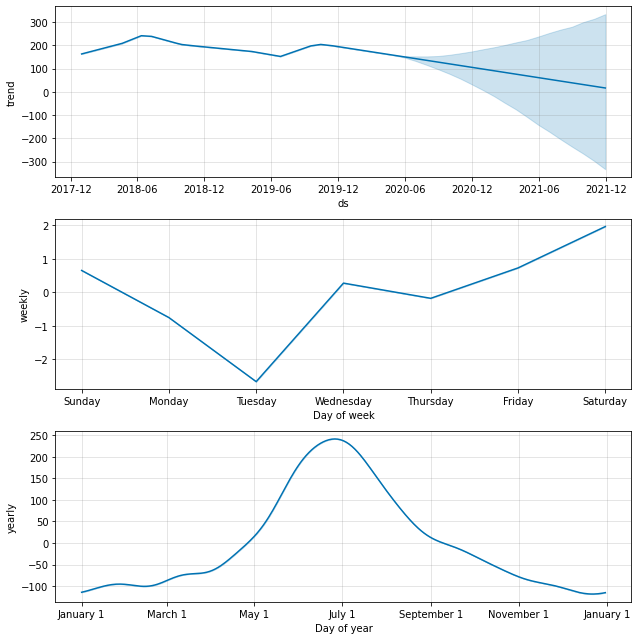

In [54]:
model_calls.plot_components(forecast_calls);

Injury calls and all calls have very similar models. It both decreases in general with time. However, there was only 2 seasons covered and it is not that much for predictive modellings. 

Seasonal Naive is good for short period prediction. Prophet is good for long term period prediction.
It picked up the general trend which is a decreasing one. 
However, only 2 seasons of data provided.
